In [1]:
import os, sys
import dotenv
dotenv.load_dotenv('../.env')

import numpy as np
import torch
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import pandas as pd
from torchvision import transforms

import wandb
from collections import defaultdict
import json
from pathlib import Path
from tqdm import tqdm
from copy import deepcopy
import warnings

sys.path.append('../')
from common import OnnxModel, BOLT_DIR
from metrics.metrics import calculate_open_loop_metrics, calculate_closed_loop_metrics
from dataloading.nvidia import NvidiaElvaDataset, NvidiaDataset

WANDB_ENTITY = os.getenv('WANDB_ENTITY')
WANDB_PROJECT = os.getenv('WANDB_PROJECT')

In [2]:
def are_locations_close(loc_a, loc_b, threshold=50):
    return np.linalg.norm(loc_a - loc_b) < threshold

def get_closest_frame_by_loc(df, target_loc):
    locations = df[['position_x', 'position_y']].to_numpy().astype(np.float32)
    df['distance_to_target'] = np.linalg.norm(locations - target_loc)
    return df.loc[df['distance_to_target'].idxmin()]

def get_closest_row_idx_by_timestamp(df, dt):
    df['timestamp'] = pd.to_datetime(df['index'])
    return (abs(df['timestamp'] - dt)).idxmin()

def get_longest_intervention_periods(df):
    df['autonomous_next'] = df['autonomous'].shift(-1)
    starts_ends_df = df[(df['autonomous'] & (df['autonomous_next'] == False)) | ((df['autonomous'] == False) & df['autonomous_next'])]
    starts_ends = [row['row_id'] for i, row in starts_ends_df.iterrows()]
    starts = np.array(starts_ends)[::2]
    ends = np.array(starts_ends)[1::2]
    longest_idxs = np.argsort(ends - starts)
    return (starts[longest_idxs], ends[longest_idxs])

def split_back_forth_drive_into_two(dataset):

    frames_df = dataset.frames
    vehicle_cmd_df = dataset.vehicle_cmd_frames
    # find the longest intervention period
    found_direction_change = False
    for forward_end, forward_start in zip(*get_longest_intervention_periods(frames_df)):
        if are_locations_close(frames_df[frames_df['row_id'] == forward_end][['position_x', 'position_y']].to_numpy(), track_direction_change_location) or \
            are_locations_close(frames_df[frames_df['row_id'] == forward_start][['position_x', 'position_y']].to_numpy(), track_direction_change_location):
            found_direction_change = True
            break

    if not found_direction_change:
        print('Couldn\'t find the longest intervention in the track direction change location')
        return None

    # split the drive into two
    df1 = frames_df[frames_df['row_id'] <= forward_end]
    df2 = frames_df[frames_df['row_id'] > forward_start]

    forward_end_ts = pd.to_datetime(df1.iloc[-1]['index'])
    backward_start_ts = pd.to_datetime(df2.iloc[0]['index'])

    forward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, forward_end_ts)
    backward_end_idx = get_closest_row_idx_by_timestamp(vehicle_cmd_df, backward_start_ts)

    df1_vehicle_cmd = vehicle_cmd_df.iloc[:forward_end_idx]
    df2_vehicle_cmd = vehicle_cmd_df.iloc[backward_end_idx:]

    # save the pandas dataframes back into NvidiaDataset objects
    dataset_forward = deepcopy(dataset)
    dataset_backward = deepcopy(dataset)
    dataset_forward.frames = df1
    dataset_forward.vehicle_cmd_frames = df1_vehicle_cmd
    dataset_backward.frames = df2
    dataset_backward.vehicle_cmd_frames = df2_vehicle_cmd

    return dataset_forward, dataset_backward

In [3]:
track_direction_change_location = np.array([-9683.68050786, -1542.68155186])
root_path = Path(BOLT_DIR) / 'end-to-end/drives-ebm-paper'
expert_ds = NvidiaDataset([root_path / '2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk'])
expert_back_ds = NvidiaDataset([root_path / '2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk'])

[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk: length=13858, filtered=2
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-11-08-59_e2e_rec_ss20_elva_back_eval_chunk: length=14249, filtered=1


In [4]:
df = pd.read_csv('ebm-experiments-final-results.csv')
# convert str to tuple
df['drive'] = df['drive'].apply(lambda x: tuple(x[1:-1].replace('\'', '').split(',')))
df['drive'] = df['drive'].apply(lambda x: [i.strip() for i in x if i != ''])
df

,training_run,model_name,real_interventions,drive,elva_mae,elva_whiteness,elva_expert_whiteness,val_mae,model_type,traj_mae,traj_rmse,traj_max,traj_failure_rate,distance,distance_per_intervention,whiteness,cmd_whiteness,expert_whiteness
0,3ftnqxcb,ebm-512-s1,9,[e2e-ebm-512-s1-day1-forward_2022-09-20-11-00-...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.483955,0.601372,1.704454,10.556534,8390.977367,932.330819,44.129417,230.578280,17.655094
1,3ftnqxcb,ebm-512-s1,4,[ebm-paper-ebm-512-s1-forward_2022-09-21-10-51...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.502133,0.617828,1.716365,10.592712,8479.229138,2119.807285,35.247937,176.928088,17.655094
2,3ftnqxcb,ebm-512-s1,1,[ebm-paper-classifier-512-forward_2022-09-22-1...,7.487386,191.060638,17.679368,8.607146,pilotnet-ebm,0.473865,0.589811,1.606098,9.690126,8453.523026,8453.523026,62.167397,287.140884,17.655094
3,3jk7cnqa,ebm-normal-1-s1,5,[e2e-ebm-normal-1-s1-day1-forward_2022-09-20-1...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.412358,0.524989,1.721364,5.836352,8473.096473,1694.619295,49.922412,119.390706,17.655094
4,3jk7cnqa,ebm-normal-1-s1,2,[ebm-paper-ebm-normal-1-s1-forward_2022-09-22-...,6.974703,152.191879,17.679368,8.437540,pilotnet-ebm,0.407956,0.512668,1.708277,5.597071,8473.696547,4236.848274,38.956632,137.220901,17.655094
5,2jvl4yhn,ebm-spatial-0-s2,5,[e2e-ebm-spatial-0-s2-day1-forward_2022-09-20-...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.436406,0.548320,1.640132,6.909590,8444.219201,1688.843840,27.796907,56.328374,17.655094
6,2jvl4yhn,ebm-spatial-0-s2,5,[ebm-paper-ebm-spatial-0-s2-forward_2022-09-21...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.442618,0.559457,1.509779,8.546063,8442.245854,1688.449171,46.829478,57.148334,17.655094
7,2jvl4yhn,ebm-spatial-0-s2,8,[ebm-paper-ebm-spatial-0-s2-forward_2022-09-22...,6.909929,125.816818,17.679368,8.738031,pilotnet-ebm,0.408279,0.524145,1.662858,6.115684,8423.292356,1052.911545,45.308797,100.601177,17.655094
8,bxd5wtqk,mae-s2,2,"[e2e-mae-s2-day1-forward_2022-09-20-11-25-14, ...",7.196932,54.846653,17.679368,7.828012,pilotnet,0.400974,0.504417,1.597662,5.848605,8516.510890,4258.255445,26.690530,37.836591,17.655094
9,bxd5wtqk,mae-s2,2,"[ebm-paper-mae-s2-forward_2022-09-21-12-22-57,...",7.196932,54.846653,17.679368,7.828012,pilotnet,0.444160,0.550030,1.700503,6.200212,8558.516801,4279.258400,29.645191,75.343871,17.655094


In [6]:
datasets_forward = {}
datasets_backward = {}

for i, row in tqdm(df.iterrows()):
    drives = row['drive']
    ds_forward = None
    ds_backward = None
    forward_metrics = {}
    backward_metrics = {}
    title_forward = None
    title_backward = None
    print(type(drives), drives)

    if len(drives) == 1:
        ds_combined = NvidiaDataset([root_path / drives[0]])
        if drives[0] not in ['2022-09-09-11-47-04', '2022-09-09-10-51-33-mdn-1-s1']: # interrupted single direction drives
            ds_forward, ds_backward = split_back_forth_drive_into_two(ds_combined)
            title_forward = drives[0] + ' (forward)'
            title_backward = drives[0] + ' (backward)'
        else:
            ds_forward = ds_combined
            title_forward = drives[0]
    elif len(drives) == 2:
        ds_forward = NvidiaDataset([root_path / drives[0]])
        ds_backward = NvidiaDataset([root_path / drives[1]])
        title_forward = drives[0]
        title_backward = drives[1]
    elif len(drives) == 3:
        assert '2022-08-31-15-18-55_elva_classifier_512_forward_continued' in drives[1]
        ds_forward = NvidiaDataset([root_path / drives[0], root_path / drives[1]])
        ds_backward = NvidiaDataset([root_path / drives[2]])
        title_forward = drives[0] + ' + continued'
        title_backward = drives[2]

    if ds_forward is not None and title_forward is not None:
        datasets_forward[title_forward] = ds_forward
    if ds_backward is not None and title_backward is not None:
        datasets_backward[title_backward] = ds_backward

2it [00:00, 12.32it/s]

<class 'list'> ['2022-09-09-11-47-04']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-47-04: length=3364, filtered=0
<class 'list'> ['2022-09-09-10-51-33-mdn-1-s1']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-51-33-mdn-1-s1: length=4700, filtered=0
<class 'list'> ['2022-09-09-10-04-05-mdn-3-s2']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-04-05-mdn-3-s2: length=38861, filtered=0
<class 'list'> ['2022-09-09-11-23-11-mdn-3-s3']
[NvidiaDataset] Using default transform: Compose(
)


4it [00:01,  3.22it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-23-11-mdn-3-s3: length=38857, filtered=0
<class 'list'> ['2022-09-09-11-00-03-mdn-5-s1']
[NvidiaDataset] Using default transform: Compose(
)


5it [00:01,  2.85it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-11-00-03-mdn-5-s1: length=38100, filtered=0
<class 'list'> ['2022-09-09-10-27-50-mdn-5-s2']
[NvidiaDataset] Using default transform: Compose(
)


6it [00:02,  2.63it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-09-10-27-50-mdn-5-s2: length=38317, filtered=0
<class 'list'> ['2022-08-31-15-37-37_elva_ebm_512_front', '2022-08-31-15-48-15_elva_ebm_512_back']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-37-37_elva_ebm_512_front: length=17873, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


7it [00:02,  2.30it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-48-15_elva_ebm_512_back: length=18822, filtered=0
<class 'list'> ['2022-08-31-16-29-08_elva_ebm_256_front', '2022-08-31-16-42-01_elva_ebm_256_back']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-29-08_elva_ebm_256_front: length=17991, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


8it [00:03,  2.02it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-42-01_elva_ebm_256_back: length=18865, filtered=0
<class 'list'> ['2022-08-31-17-16-19_elva_ebm_128_front', '2022-08-31-17-26-53_elva_ebm_128_back']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-16-19_elva_ebm_128_front: length=17972, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


9it [00:03,  1.88it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-26-53_elva_ebm_128_back: length=18390, filtered=0
<class 'list'> ['2022-08-31-14-52-25_elva_classifier_512_forward', '2022-08-31-15-18-55_elva_classifier_512_forward_continued', '2022-08-31-15-26-05_elva_classifier_512_back']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-14-52-25_elva_classifier_512_forward: length=5921, filtered=0
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-18-55_elva_classifier_512_forward_continued: length=11356, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


10it [00:04,  1.81it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-15-26-05_elva_classifier_512_back: length=18521, filtered=0
<class 'list'> ['2022-08-31-16-00-20_elva_classifier_256_front', '2022-08-31-16-11-28_elva_classifier_256_back']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-00-20_elva_classifier_256_front: length=18051, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


11it [00:04,  1.84it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-11-28_elva_classifier_256_back: length=18668, filtered=0
<class 'list'> ['2022-08-31-16-53-38_elva_classifier_128_front', '2022-08-31-17-04-28_elva_classifier_128_back']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-16-53-38_elva_classifier_128_front: length=18373, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


12it [00:05,  1.78it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-08-31-17-04-28_elva_classifier_128_back: length=18543, filtered=0
<class 'list'> ['2022-09-02-11-04-39_elva_ebm_512_s1_rep1']
[NvidiaDataset] Using default transform: Compose(
)


13it [00:06,  1.75it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-04-39_elva_ebm_512_s1_rep1: length=38117, filtered=0
<class 'list'> ['2022-09-02-11-27-02_elva_ebm_512_s1_rep2']
[NvidiaDataset] Using default transform: Compose(
)


14it [00:06,  1.74it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-27-02_elva_ebm_512_s1_rep2: length=37417, filtered=0
<class 'list'> ['2022-09-02-11-48-55_elva_ebm_512_s1_rep3']
[NvidiaDataset] Using default transform: Compose(
)


15it [00:07,  1.85it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-11-48-55_elva_ebm_512_s1_rep3: length=37321, filtered=0
<class 'list'> ['2022-09-08-10-13-30_ebm-512-s1']
[NvidiaDataset] Using default transform: Compose(
)


16it [00:07,  1.92it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-10-13-30_ebm-512-s1: length=37129, filtered=0
<class 'list'> ['2022-09-08-10-38-33_ebm_512_s2']
[NvidiaDataset] Using default transform: Compose(
)


17it [00:08,  2.01it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-10-38-33_ebm_512_s2: length=37368, filtered=0
<class 'list'> ['2022-09-08-11-01-21_ebm-512-s3']
[NvidiaDataset] Using default transform: Compose(
)


18it [00:08,  1.89it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-01-21_ebm-512-s3: length=37803, filtered=0
<class 'list'> ['2022-09-02-09-54-31_elva_mae_s1_rep1']
[NvidiaDataset] Using default transform: Compose(
)


19it [00:09,  1.75it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-09-54-31_elva_mae_s1_rep1: length=37619, filtered=0
<class 'list'> ['2022-09-02-10-20-29_elva_mae_s1_rep2']
[NvidiaDataset] Using default transform: Compose(
)


20it [00:09,  1.80it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-10-20-29_elva_mae_s1_rep2: length=37279, filtered=0
<class 'list'> ['2022-09-02-10-42-07_elva_mae_s1_rep3']
[NvidiaDataset] Using default transform: Compose(
)


21it [00:10,  1.91it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-02-10-42-07_elva_mae_s1_rep3: length=38435, filtered=0
<class 'list'> ['2022-09-08-11-26-29_mae-s1']
[NvidiaDataset] Using default transform: Compose(
)


22it [00:10,  2.01it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-26-29_mae-s1: length=37241, filtered=0
<class 'list'> ['2022-09-08-11-49-08_mae-s2']
[NvidiaDataset] Using default transform: Compose(
)


23it [00:11,  2.10it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-11-49-08_mae-s2: length=37280, filtered=0
<class 'list'> ['2022-09-08-12-13-25_mae-s3']
[NvidiaDataset] Using default transform: Compose(
)


24it [00:11,  2.16it/s]

/data/Bolt/end-to-end/drives-ebm-paper/2022-09-08-12-13-25_mae-s3: length=38024, filtered=0
<class 'list'> ['e2e-ebm-512-s1-forward_2022-09-13-10-33-34', 'e2e-ebm-512-s1-backward_2022-09-13-10-44-25']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-512-s1-forward_2022-09-13-10-33-34: length=18211, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


25it [00:12,  2.00it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-512-s1-backward_2022-09-13-10-44-25: length=18448, filtered=0
<class 'list'> ['e2e-ebm-50percent-s2-forward_2022-09-13-11-19-28', 'e2e-ebm-50percent-s2-backward_2022-09-13-11-30-33']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-50percent-s2-forward_2022-09-13-11-19-28: length=18740, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


26it [00:12,  1.82it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-50percent-s2-backward_2022-09-13-11-30-33: length=18767, filtered=0
<class 'list'> ['e2e-ebm-20percent-s2-forward_2022-09-13-12-10-23', 'e2e-ebm-20percent-s2-backward_2022-09-13-12-21-25']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-20percent-s2-forward_2022-09-13-12-10-23: length=18348, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


27it [00:13,  1.73it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-ebm-20percent-s2-backward_2022-09-13-12-21-25: length=18946, filtered=0
<class 'list'> ['e2e-classifier-512-forward_2022-09-13-10-56-50', 'e2e-classifier-512-backward_2022-09-13-11-07-29']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-512-forward_2022-09-13-10-56-50: length=17994, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


28it [00:14,  1.70it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-512-backward_2022-09-13-11-07-29: length=18350, filtered=0
<class 'list'> ['e2e-classifier-50percent-s1-forward_2022-09-13-11-42-53', 'e2e-classifier-50percent-s1-backward_2022-09-13-11-53-59']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-50percent-s1-forward_2022-09-13-11-42-53: length=18860, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


29it [00:14,  1.66it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-50percent-s1-backward_2022-09-13-11-53-59: length=18902, filtered=0
<class 'list'> ['e2e-classifier-20percent-s2-forward_2022-09-13-12-33-22', 'e2e-classifier-20percent-s2-backward_2022-09-13-12-44-44']
[NvidiaDataset] Using default transform: Compose(
)
/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-20percent-s2-forward_2022-09-13-12-33-22: length=19363, filtered=0
[NvidiaDataset] Using default transform: Compose(
)


30it [00:15,  1.95it/s]

/data/Bolt/end-to-end/drives-ebm-paper/e2e-classifier-20percent-s2-backward_2022-09-13-12-44-44: length=18792, filtered=0


### Intersection handling

In [5]:
from IPython.display import Image

In [209]:
dff = datasets_forward['2022-09-08-10-13-30_ebm-512-s1 (forward)'].frames
dfb = datasets_backward['2022-09-08-10-13-30_ebm-512-s1 (backward)'].frames
# intersection_start_forward = dff[dff['position_x'] < -8040].iloc[0]
# intersection_start_backward = dfb[dfb['position_x'] > -8085].iloc[0]
# intersection_start_forward_loc = intersection_start_forward[['position_x', 'position_y']].to_numpy().astype(np.float32)
# intersection_start_backward_loc = intersection_start_backward[['position_x', 'position_y']].to_numpy().astype(np.float32)

# Image(intersection_start_forward.image_path)

In [6]:
from copy import deepcopy

DURATION_SEC = 5
INTERSECTIONS = ['village-forward', 'village-backward', 'early-forward', 'early-backward']

def crop_intersection(ds_forward, ds_backward, place='village-forward'):
    dataset = ds_forward if 'forward' in place else ds_backward
    intersection_ds = deepcopy(dataset)
    inter_fr = dataset.frames

    if place == 'village-forward':
        intersection_start = inter_fr[inter_fr['position_x'] < -8040].iloc[0]
    elif place == 'village-backward':
        intersection_start = inter_fr[inter_fr['position_x'] > -8085].iloc[0]
    elif place == 'early-forward':
        intersection_start = inter_fr[inter_fr['position_y'] > -3495].iloc[0]
    elif place == 'early-backward':
        intersection_start = inter_fr[inter_fr['position_x'] > -9075].iloc[0]

    inter_fr = inter_fr[inter_fr['row_id'] >= intersection_start['row_id']]
    inter_fr = inter_fr[inter_fr['row_id'] <= intersection_start['row_id'] + DURATION_SEC * 30]
    intersection_ds.frames = inter_fr
    return intersection_ds

In [7]:
from ebm import optimizers
from pilotnet import PilotNet, PilotnetEBM, PilotnetClassifier, PilotnetMDN
from classifier.infer import ClassifierInferrer
from mdn.infer import MDNInferrer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def initialize_model(model_path, model_type, config={}):
    inference_config = None
    inference_wrapper = None

    if model_type == 'pilotnet':
        model = PilotNet()

    elif model_type == 'pilotnet-ebm':
        n_samples = config.get('n_samples', 512)
        n_dfo_iters = config.get('ebm_dfo_iters', 0)
        ebm_constant_samples = config.get('ebm_constant_samples', True)
        steering_bound = config.get('steering_bound', 4.5)
        
        inference_config = optimizers.DerivativeFreeConfig(
            bound=steering_bound,
            train_samples=n_samples,
            inference_samples=n_samples,
            iters=n_dfo_iters,
        )
        inference_wrapper = optimizers.DFOptimizerConst if ebm_constant_samples else optimizers.DFOptimizer
        model = PilotnetEBM()
        model = inference_wrapper(model, inference_config)

    elif model_type == 'pilotnet-classifier':
        steering_bound = config.get('steering_bound', 4.5)
        weights = torch.load(model_path, map_location=torch.device('cpu'))
        for _, weight in weights.items(): pass # access output layer weights
        output_layer_size = weight.shape[0]
        model = PilotnetClassifier(output_layer_size)
        model = ClassifierInferrer(model, steering_bound, output_layer_size)

    elif model_type == 'pilotnet-mdn':
        n_gaussians = config.get('n_gaussians', 5)
        model = PilotnetMDN(n_gaussians=n_gaussians)
        model = MDNInferrer(model)

    else:
        raise ValueError(f'Unknown model type: {model_type}')

    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.to(device)
    model.eval()

    raw_model = model
    if model_type in ['pilotnet-mdn', 'pilotnet-classifier']:
        raw_model = model.model
    elif model_type in ['pilotnet-ebm']:
        raw_model = model.ebm

    return model, raw_model

In [13]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import dataloading.nvidia as nv

BOUND = 4.5
N_SAMPLES = 512


def get_full_model_outputs(model_name, model_type, dataloader, config={}):
    '''Runs the torch model to extract energy/etc'''

    path_to_model = os.path.join('../_models', model_name + '.pt')

    model, raw_model = initialize_model(path_to_model, model_type, config=config)

    pred_angles = []
    pred_distributions = []

    for i, (input, target, _) in enumerate(tqdm(dataloader)):
        inputs = input['image'].to(device)
        target = target.to(device, torch.float32)

        with torch.no_grad():
            preds = model(inputs)

        if model_type == 'pilotnet-ebm':
            pred_angle = preds[0]
            energy = preds[1]
            energy = torch.squeeze(energy).cpu().detach().numpy()
            pred_distributions.append(energy)
        elif model_type == 'pilotnet-mdn':
            pred_angle = preds
            pi, sigma, mu = raw_model(inputs)
            inverted_probas = get_mdn_density(pi, sigma, mu)
            inverted_probas = torch.squeeze(inverted_probas).cpu().detach().numpy()
            pred_distributions.append(inverted_probas)
        elif model_type == 'pilotnet-classifier':
            pred_angle = preds
            logits = raw_model(inputs)
            logits = torch.squeeze(logits).cpu().detach().numpy()
            pred_distributions.append(logits)
        elif model_type == 'pilotnet':
            pred_angle = preds
            pred_distributions.append([])
        
        preg_angle_cpu = pred_angle.cpu().detach().numpy()
        pred_angles.append(preg_angle_cpu)

    pred_angles = np.concatenate(pred_angles)
    true_angles = dataloader.dataset.frames.steering_angle.to_numpy()

    assert len(pred_angles) == len(true_angles), f'len(pred_angles)={len(pred_angles)} != len(true_angles)={len(true_angles)}'

    pred_distributions = np.vstack(pred_distributions)

    del inputs
    del target
    del preds
    del model
    del raw_model
    torch.cuda.empty_cache()

    return pred_angles, true_angles, pred_distributions


In [30]:
import cv2

def make_video(image_paths, output_path, fps=30):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width,height))
    for image_path in image_paths:
        video.write(cv2.imread(image_path))
    cv2.destroyAllWindows()
    video.release()

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator, FixedLocator
from mdn.mdn import mdn_logprob
import matplotlib.patheffects as pe


def steering_angle_to_bin_idx(angle_degs, num_samples=512, bound=4.5):
    angle_rads = np.radians(angle_degs)
    bin_idx = (angle_rads) * (num_samples-1) / (bound*2) + (num_samples-1)/2
    return bin_idx

def bin_idx_to_steering_angle(bin_idx, num_samples=512, bound=4.5):
    angle_rads = (bin_idx - (num_samples-1)/2) * bound*2 / (num_samples-1)
    angle_degs = np.degrees(angle_rads)
    return angle_degs

def get_ebm_density(energy, softmin=False):
    if softmin:
        energy = torch.nn.Softmin()(torch.tensor(energy))
    normalized = (energy - energy.min()) / (energy.max() - energy.min())
    return normalized

def get_classifier_density(logits):
    probs = (logits - logits.min()) / (logits.max() - logits.min())
    inverted_probs = 1 - probs
    return inverted_probs

def get_mdn_density(pi, sigma, mu):
    targets_grid = torch.linspace(-BOUND, BOUND, N_SAMPLES).repeat(pi.shape[0], 1).reshape(-1, 1).to(pi.device)
    pis_repeated = torch.repeat_interleave(pi, N_SAMPLES, dim=0)
    sigmas_repeated = torch.repeat_interleave(sigma, N_SAMPLES, dim=0)
    mus_repeated = torch.repeat_interleave(mu, N_SAMPLES, dim=0)

    logprob_grid = mdn_logprob(pis_repeated, sigmas_repeated, mus_repeated, targets_grid).reshape(-1, N_SAMPLES)
    probs = torch.exp(logprob_grid)
    inverted_probs = 1 - probs
    normalized = (inverted_probs - inverted_probs.min()) / (inverted_probs.max() - inverted_probs.min())
    return normalized

def plot_pred_distribution(ax, pred_distribution, pred_angles, true_angles, model_type, model_label, softmin=False, bound=4.5, num_samples=512):

    if model_type == 'pilotnet-ebm':
        mappable = ax.imshow(get_ebm_density(pred_distribution), aspect=2.6, cmap='terrain')
        
    elif model_type == 'pilotnet-mdn':
        mappable = ax.imshow(pred_distribution, aspect=2.6, cmap='terrain')

    elif model_type == 'pilotnet-classifier':
        mappable = ax.imshow(get_classifier_density(pred_distribution), aspect=2.6, cmap='terrain')

    elif model_type == 'pilotnet':
        mappable = None
        ax.set_xlim(0, num_samples)
        ax.set_ylim(DURATION_SEC*30+1, 0) # 211 = 7 seconds * 30 fps + 1
        ax.set_aspect(2.6)

    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xlabel('Steering Angle')
    ax.set_ylabel('Time (s)')
    tick_formatter = FuncFormatter(lambda x, pos: int(bin_idx_to_steering_angle(x, num_samples=num_samples, bound=bound).round()))
    tick_locator = FixedLocator(steering_angle_to_bin_idx([-225, -180, -135, -90, -45, 0, 45, 90, 135, 180, 225]))
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.xaxis.set_major_locator(tick_locator)
    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(x)/30))

    true_angles = steering_angle_to_bin_idx(np.degrees(true_angles), num_samples=num_samples, bound=bound)
    pred_angles = steering_angle_to_bin_idx(np.degrees(pred_angles), num_samples=num_samples, bound=bound)
    ax.plot(true_angles, np.arange(0, len(true_angles)), color='white', linestyle='dashed', linewidth=2, label='Human-driven', path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])

    ax.plot(pred_angles, np.arange(0, len(pred_angles)), color='red', linestyle='dashed', linewidth=2, label='Model prediction')
    ax.set_title(model_label)
    # ax.legend()

    return mappable

In [10]:
model_name_to_label = {
    'classifier-512': 'Classification',
    'ebm-512-s1': 'EBM',
    'mdn-5-s1': 'MDN',
    'mae-s2': 'MAE',
    'ebm-normal-1-s1': 'EBM (temporal regularization)',
    'ebm-spatial-0-s2': 'EBM (spatial targets)',
}

In [31]:
intersection_dataset = crop_intersection(expert_ds, expert_back_ds, 'early-forward')
frame = intersection_dataset.frames.iloc[60].image_path
print(frame)
!code $frame

/data/Bolt/end-to-end/drives-ebm-paper/2021-10-26-10-49-06_e2e_rec_ss20_elva_eval_chunk/front_wide/1635234891573036909.png


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Intersection "village-forward"


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Intersection "village-backward"


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Intersection "early-forward"


100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Intersection "early-backward"


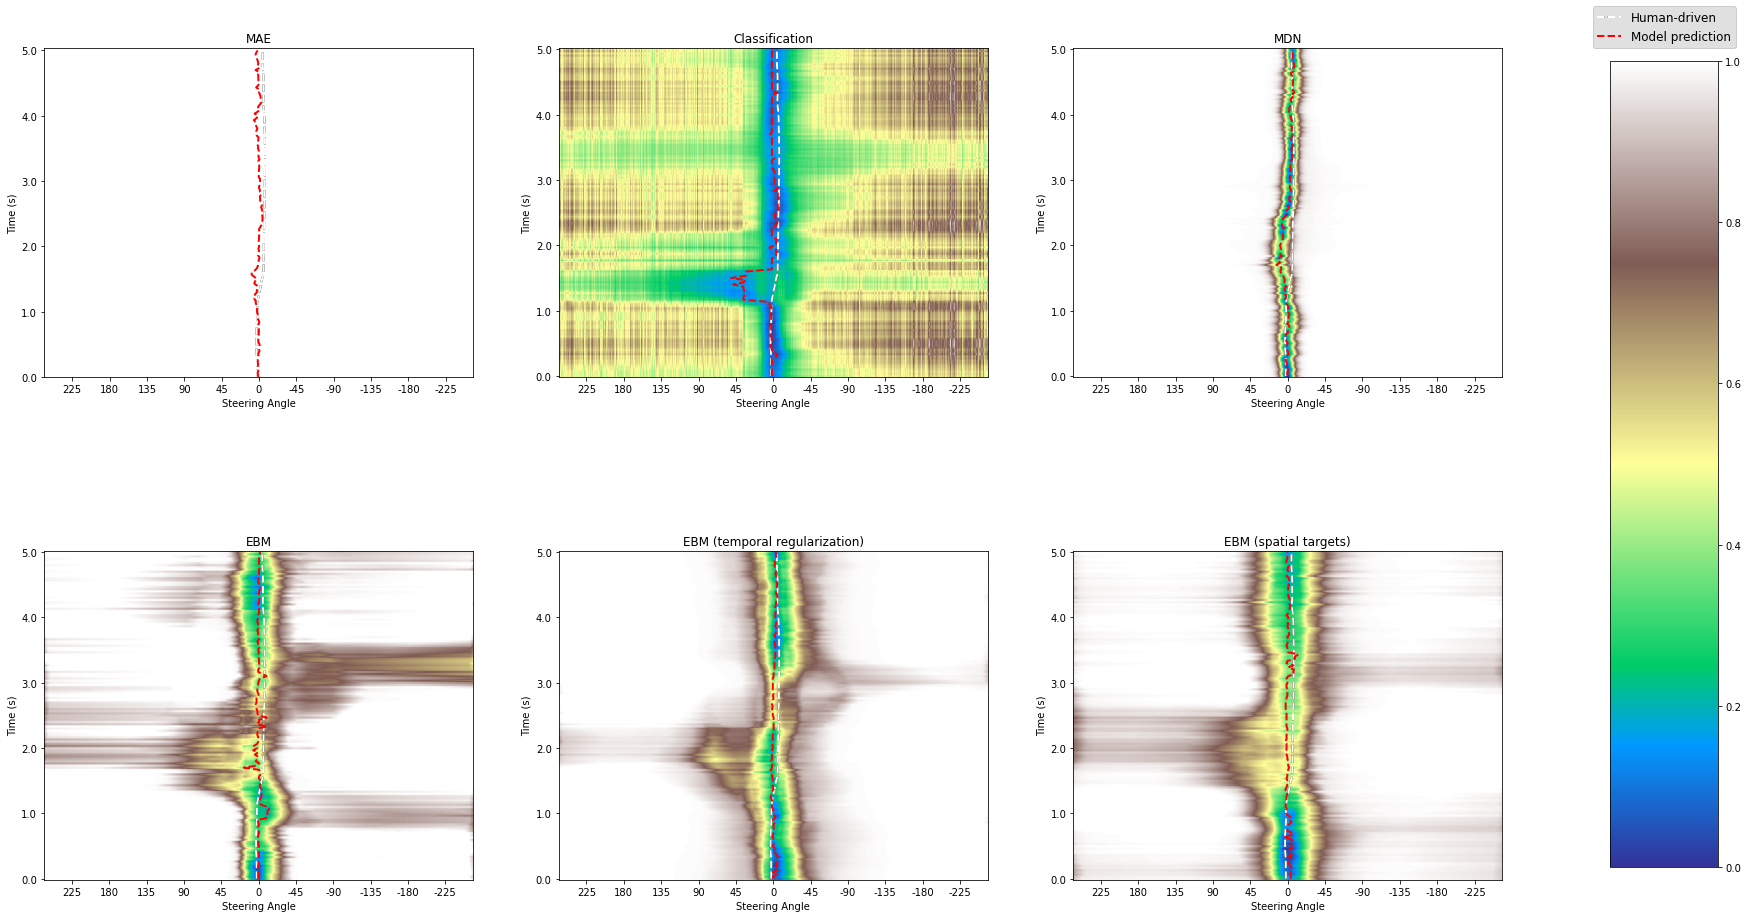

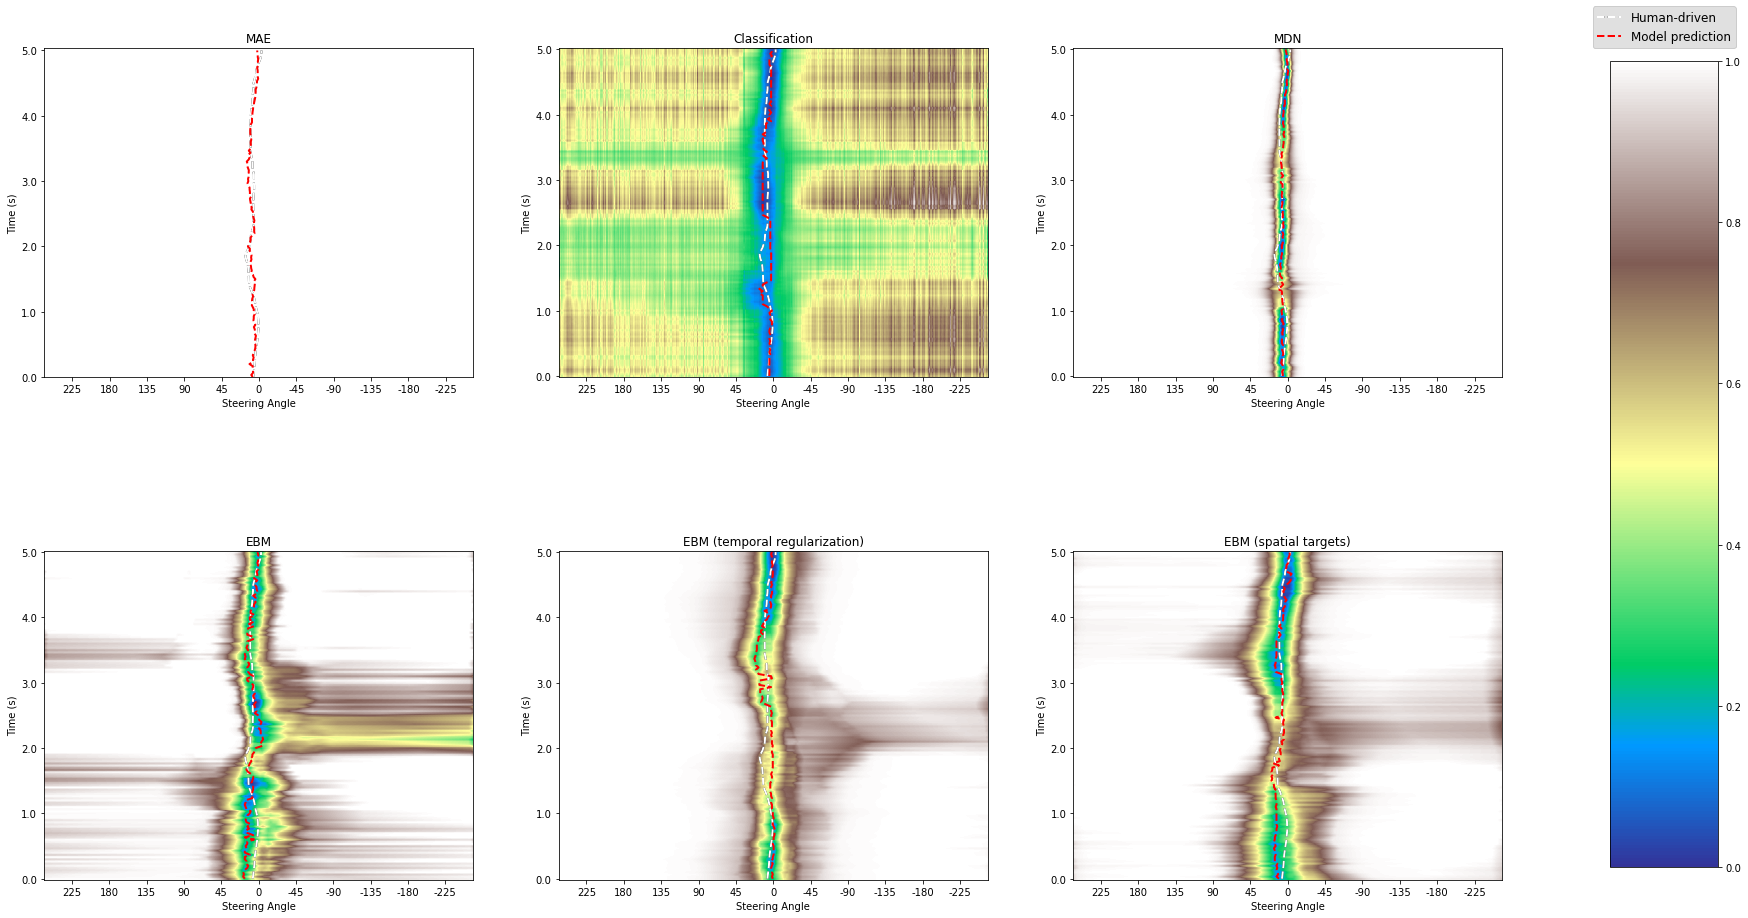

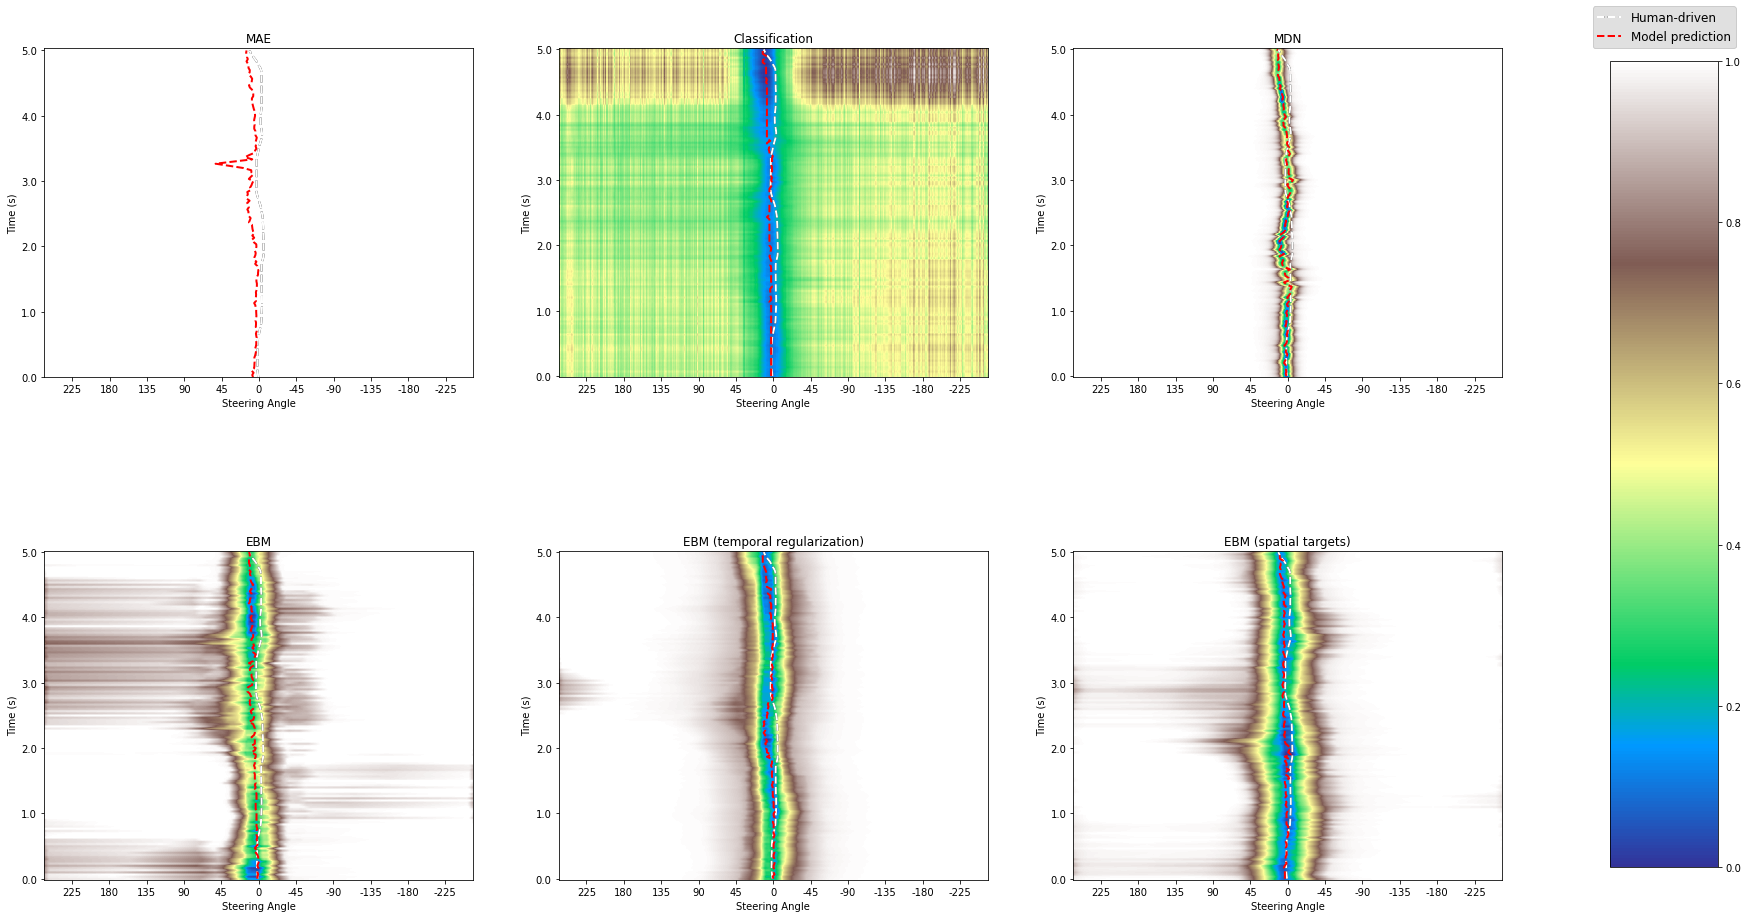

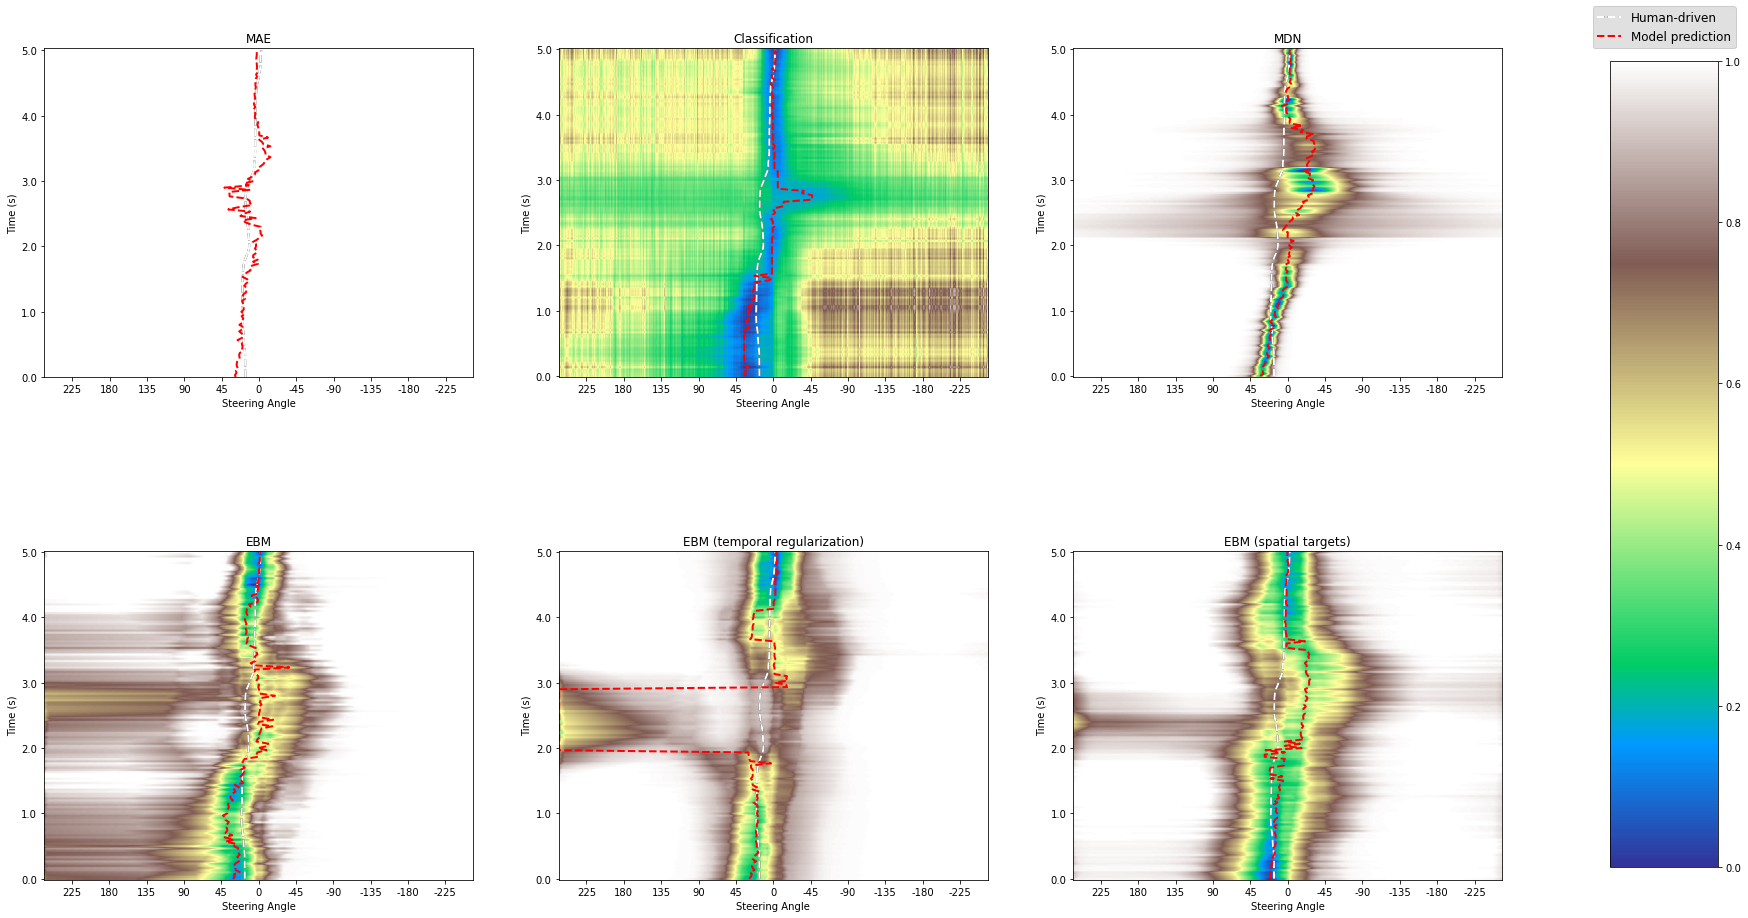

In [20]:
# prepare models
models = df.groupby('model_name').first().reset_index()[['model_name','model_type']].values
models = models[[4, 0, 5, 1, 2, 3]]

for intersection in INTERSECTIONS:

    # prepare intersection dataset
    expert_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
    expert_back_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
    intersection_dataset = crop_intersection(expert_ds, expert_back_ds, intersection)
    loader = DataLoader(intersection_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

    # plot predictions
    fig, axes = plt.subplots(2, 3, figsize=(30, 16))
    for (model_name, model_type), ax in zip(models, axes.flatten()):
        pred_angles, true_angles, pred_distributions = get_full_model_outputs(model_name, model_type, loader)
        mappable = plot_pred_distribution(ax, pred_distributions, pred_angles, true_angles, model_type, model_name_to_label[model_name])

    # add colorbar
    fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.2, bottom=0.1, top=0.9)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(mappable, cax=cbar_ax)

    # add legend
    handles, labels = axes.flatten()[-1].get_legend_handles_labels()
    cbar_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})

    # fig.suptitle(f'Intersection "{intersection}"')
    print(f'Intersection "{intersection}"')
    fig.show()

In [348]:
model_name = 'mae-s2'
model_type = 'pilotnet'

expert_ds.transform = transforms.Compose([nv.NvidiaCropWide(), nv.Normalize()])
intersection_dataset = crop_intersection(expert_ds)

pred_angles, true_angles, pred_distributions = get_full_model_outputs(model_name, model_type, intersection_dataset)

print(pred_angles.shape)
print(true_angles.shape)
print(pred_distributions.shape)


100%|██████████| 7/7 [00:06<00:00,  1.03it/s]

(211, 1)
(211,)
(7, 0)


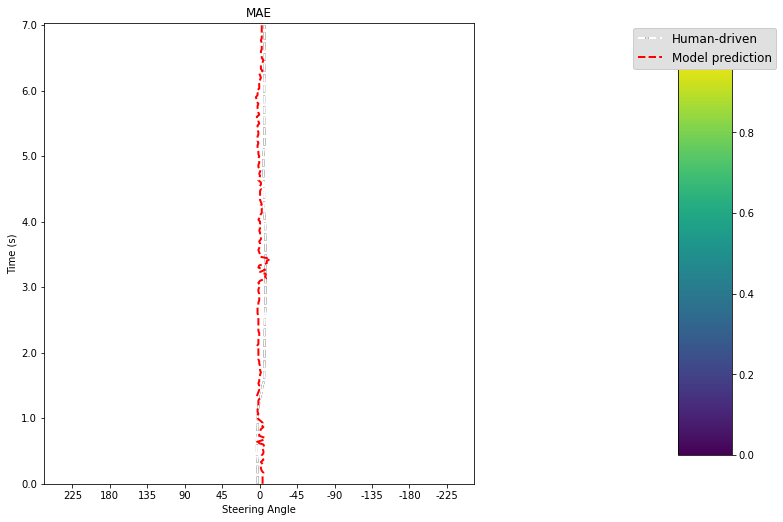

In [391]:
fig, ax = plt.subplots(1, figsize=(15, 8))


model_names = df.groupby('model_name').first()

model_type = 'pilotnet'
model_label = 'MAE'

mappable = plot_pred_distribution(ax, pred_distributions, pred_angles, true_angles, model_type, model_label)

# fig.legend(facecolor='#e0e0e0', framealpha=1)

fig.subplots_adjust(right=0.8, hspace=0.2, wspace=0.2, bottom=0.1, top=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(mappable, cax=cbar_ax)

handles, labels = ax.get_legend_handles_labels()
cbar_ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=1, facecolor='#e0e0e0', framealpha=1, prop={'size': 12})


plt.show()